# Notebook article: *Strong field double ionization : The phase space perspective*

---

> [Cristel Chandre](https://orcid.org/0000-0003-3667-259X) and [Jonathan Dubois](https://orcid.org/0000-0002-6976-5488)

based on [[F. Mauger, C. Chandre, T. Uzer, *Strong field double ionization: The phase space perspective*, Physical Review Letters 102, 173002 (2009)](https://dx.doi.org/10.1103/PhysRevLett.102.173002)]

*Abstract*: We identify the phase-space structures that regulate atomic double ionization in strong ultrashort laser pulses. The emerging dynamical picture complements the recollision scenario by clarifying the distinct roles played by the recolliding and core electrons, and leads to verifiable predictions on the characteristic features of the "knee", a hallmark of the nonsequential process.

## Introduction

One of the most striking surprises of recent years in intense laser-matter interactions has come from multiple ionization by intense short laser pulses:  Correlated (nonsequential) double ionization rates were found to be 
several orders of magnitude higher than the uncorrelated sequential mechanism allows. This discrepancy has made the characteristic "knee" shape in the 
double ionization yield versus intensity plot into one of the most dramatic manifestations of electron-electron correlation in nature. The precise mechanism that makes correlation so effective is far from settled. Different scenarios have been proposed to explain the mechanism behind ionization [1-18] and have been confronted with experiments [19,20], the recollision scenario [2,3], in which the ionized electron is hurled back at the ion core by the laser, being in best accord with experiments. In Fig. 1, a typical double ionization probability as a function of the intensity of the laser field is plotted. Similar knees have been observed in experimental data [1,4,20-26] and successfully reproduced by quantal computations on atoms and molecules [5,27-29]. In a recent series of articles [8,9,12,13,29-31] characteristic features of double ionization were reproduced using classical trajectories and this success was ascribed to the paramount role of correlation [12]. Indeed, entirely classical interactions turn out to be adequate to generate the strong two-electron correlation needed for double ionization. 

In this Letter, we complement the well-known recollision scenario by identifying the organizing principles which explain the statistical properties of the classical trajectories such as ionization probabilities. In addition to the dynamical picture of the ionized electron provided by the recollision scenario, we connect the dynamics of the core electron and the energy flow leading to double ionization to relevant phase space structures (periodic orbits or invariant tori). The resulting picture leads to two verifiable predictions for key points which make up the knee in Fig. 1: namely the laser intensity where nonsequential double ionization is maximal and the intensity where the double ionization is complete. Of course, the saturation intensity emerges naturally in quantum mechanical calculations (e.g., Refs. [5,28]) provided they cover a wide enough intensity range.

## Hamiltonian model

We work with the classical Hamiltonian model of the helium atom with soft Coulomb potentials [32,33]. The Hamiltonian is given by [10]:
$$
{\mathcal H}(x,y,p_{x}, p_{y},t) =  \frac{p_{x}^{2}}{2} + \frac{ 
p_{y}^{2}}{2}+(x+y)E(t) + \frac{1}{\sqrt{(x-y)^{2}+b^2}} - \frac{2}{\sqrt{x^{2}+a^2}} - \frac{2}{\sqrt{y^{2}+a^2}}, \tag{1}$$

where $x$, $y$ and $p_{x}$, $p_{y}$ are the positions and 
(canonically conjugate) momenta of each electron respectively. The energy is initially fixed at the ground state ${\cal E}_g$ [34].
The laser field is modeled by a sinusoidal pulse with an envelope, i.e. 
$E(t)= E_{0} \ f(t) \ \sin \omega t$ where $E_{0}$ is the maximum amplitude and $\omega$ the laser frequency. The 
pulse envelope $f(t)$ is chosen as a trapezoidal function with two laser cycle ramp-up and two laser cycle ramp-down [12,13,29,30]. 
Typical ionizing trajectories of Hamiltonian (1) show two 
qualitatively different routes to double ionization: 
nonsequential double ionization (NSDI), where the two electrons leave 
the core (inner) region at about the same time, and sequential double 
ionization (SDI), where one electron leaves the inner region long time 
after the other one has ionized.

In [15]:
#@title Parameters {display-mode: "form"}
#@markdown Atom
a = 1.0 #@param {type:"number"}
b = 1.0 #@param {type:"number"}
E_g = -2.24 #@param {type:"number"}

#@markdown Field
Wavelength_in_nm = 780 #@param {type:"number"}
Pulse_duration_in_lc = 8 #@param {type:"integer"}
params_envelop = (2, Pulse_duration_in_lc-4, 2, 2)

import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


class Atom:
    def __init__(self, a, b, ground_state_energy, size=5.0, thresh=100):
        self.a = a
        self.b = b
        self.a2 = a ** 2
        self.b2 = b ** 2
        self.E = ground_state_energy
        self.size = size
        self.thresh = thresh


class Field:
    def __init__(self, wavelength, intensity=[], envelope=[], params_envelop=[]):
        self.wavelength = wavelength
        self.frequency = 45.597 / wavelength
        self.period = 2.0 * np.pi / self.frequency
        self.intensity = intensity
        self.amplitude = 5.338e-9 * np.sqrt(self.intensity)
        self.envelope = envelope
        self.params = params_envelop
        self.times = np.cumsum(self.params)
        self.tf = np.sum(self.params) * self.period


class Integration:
    def __init__(self, N, step, precision=np.float32):
        self.N = N
        self.h = step
        self.precision = precision


def trapezoidal(t, field):
    tau = t / field.period
    if tau < field.times[0]:
        return tau / field.times[0]
    elif field.times[0] <= tau <= field.times[1]:
        return 1.0
    elif field.times[1] < tau < field.times[2]:
        return (field.times[2] - tau) / field.params[2]
    else:
        return 0.0


def potential_2e(atom, x, is_deriv=False):
    r12 = x[0, ] - x[1, ]
    if is_deriv:
        dv_dt = 2.0 * x / np.power(x ** 2 + atom.a2, 1.5)
        rho12 = r12 / np.power(r12 ** 2 + atom.b2, 1.5)
        dv_dt[0, ] -= rho12
        dv_dt[1, ] += rho12
        return dv_dt
    else:
        return - 2.0 / np.sqrt(x[0, ] ** 2 + atom.a2) - 2.0 / np.sqrt(x[1, ] ** 2 + atom.a2) \
               + 1.0 / np.sqrt(r12 ** 2 + atom.b2)


def potential_1e(atom, x, is_deriv=False):
    if is_deriv:
        return 2.0 * x / np.power(x ** 2 + atom.a2, 1.5)
    else:
        return - 2.0 / np.sqrt(x ** 2 + atom.a2) 


def generate_initial_conditions(atom, integration):
    yf = np.empty((4, 0), dtype=integration.precision)
    nt = 0
    while nt <= integration.N - 1:
        x_rand = 2.0 * atom.size * np.random.random((2, integration.N)).astype(integration.precision) \
                 - atom.size
        values_potential = potential_2e(atom, x_rand)
        index = (values_potential >= atom.E)
        x_rand = x_rand[:, np.logical_not(index)]
        values_potential = values_potential[np.logical_not(index)]
        length_valid = len(values_potential)
        p_rand = 2.0 * np.random.random((2, length_valid)).astype(integration.precision) - 1.0
        p_rand *= np.sqrt(2.0 * (atom.E - values_potential))
        nt += length_valid
        y = np.concatenate([x_rand, p_rand], axis=0)
        yf = np.concatenate([yf, y], axis=1)
    return yf[:4, :integration.N]


my_atom = Atom(a=a, b=b, ground_state_energy=E_g, thresh=100)

## Figure 1: Double ionization (DI) probability for Hamiltonian (1) as a function of the intensity of the field $I$.

_________________________________________________________________________________________
DI probability for I = 3.00e+13 W/cm2 : 0.0000   (59 seconds)
DI probability for I = 4.43e+13 W/cm2 : 0.0004   (59 seconds)
DI probability for I = 6.55e+13 W/cm2 : 0.0018   (59 seconds)
DI probability for I = 9.68e+13 W/cm2 : 0.0050   (59 seconds)
DI probability for I = 1.43e+14 W/cm2 : 0.0124   (59 seconds)
DI probability for I = 2.11e+14 W/cm2 : 0.0231   (48 seconds)
DI probability for I = 3.12e+14 W/cm2 : 0.0329   (24 seconds)
DI probability for I = 4.61e+14 W/cm2 : 0.0442   (17 seconds)
DI probability for I = 6.82e+14 W/cm2 : 0.0462   (13 seconds)
DI probability for I = 1.01e+15 W/cm2 : 0.0466   (12 seconds)
DI probability for I = 1.49e+15 W/cm2 : 0.0442   (12 seconds)
DI probability for I = 2.20e+15 W/cm2 : 0.0480   (13 seconds)
DI probability for I = 3.25e+15 W/cm2 : 0.0526   (12 seconds)
DI probability for I = 4.80e+15 W/cm2 : 0.0801   (11 seconds)
DI probability for I = 7.10e+15 W/cm2 : 0.

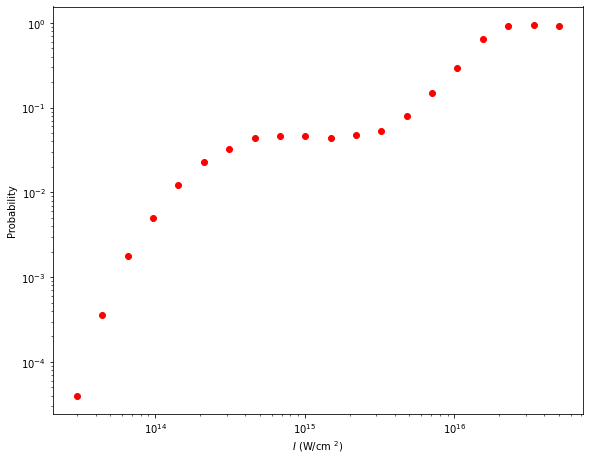

In [16]:
#@title Parameters {display-mode: "form"}
I_min = 3e13 #@param {type:"number"}
I_max = 5e16 #@param {type:"number"}
Number_of_Intensities =  20 #@param {type:"integer"}
N = 50000
Precision = "single"
h_step = 0.05

if Precision == "single":
    precision_name = np.float32
elif Precision == "double":
    precision_name = np.float64
parameters = Integration(N=N, step=h_step, precision=precision_name)
    

def eqn_motion_fig1(x, atom, field, integration):
    t = 0.0
    xf = x.copy()
    while t <= field.tf:
        e0_eff = integration.precision(field.amplitude * field.envelope(t, field) * np.sin(field.frequency * t))
        xf[:2, ] += integration.h * 0.5 * xf[2:, ]
        xf[2:, ] -= integration.h * (potential_2e(atom, xf[:2, ], is_deriv=True) + e0_eff)
        xf[:2, ] += integration.h * 0.5 * xf[2:, ]
        t += integration.h
    return xf


print("_________________________________________________________________________________________")
Intensities = 10 ** np.linspace(np.log10(I_min), np.log10(I_max), Number_of_Intensities)
start = time.time()
proba_di = np.zeros(Number_of_Intensities)
for it in range(Number_of_Intensities):
    X0 = parameters.precision(generate_initial_conditions(my_atom, parameters))
    my_field = Field(wavelength=Wavelength_in_nm, intensity=Intensities[it], envelope=trapezoidal, params_envelop=params_envelop)
    start_di = time.time()
    Xf = eqn_motion_fig1(X0, my_atom, my_field, parameters)
    cond_di = (np.abs(Xf[0, ]) >= my_atom.thresh) & (np.abs(Xf[1, ]) >= my_atom.thresh)
    proba_di[it] = float(np.count_nonzero(cond_di) / parameters.N)
    end_di = time.time()
    print("DI probability for I = {:.2e} W/cm2 : {:.4f}   ({} seconds)".format(Intensities[it], proba_di[it], int(np.rint(end_di-start_di))))
    if proba_di[it] == 0:
        parameters.N = N
    else:
        parameters.N = min(N, int(np.floor(N/100/proba_di[it])))
end = time.time()
print("_________________________________________________________________________________________")
print("Computational time: {} minutes".format(int(np.rint((end-start)/60))))
print("_________________________________________________________________________________________")

plt.figure(figsize=(9.5,7.5))
plt.xlabel('$I$ (W/cm $^2$)')
plt.ylabel('Probability')
plt.loglog(Intensities, proba_di, marker='o', color='r', linestyle='None', label='Double ionization')
plt.show()

## Dynamics without the field

We first analyze the dynamics of Hamiltonian (1) without the field ($E_0=0$) using linear stability properties such as obtained by the finite-time Lyapunov (FTL) exponents [35,36]. With each initial condition on a plane [e.g., $(x,p_x)$ with $y=0$, and $p_y$ determined by ${\mathcal H}={\mathcal E}_g$ on Fig. 2] for Hamiltonian (1), we associate a coefficient which quantifies the degree of chaos experienced by the trajectory up to a given time. 
A typical FTL map is depicted in Fig. 2 
for Hamiltonian (1) without the field. It clearly displays strong and global chaos by showing fine details of the 
stretching and folding of trajectories [35]. In particular, there are no regular elliptic islands of stability contrary to what is common with Hamiltonian systems on a bounded energy manifold. By examining typical trajectories, we notice that the motion of the two electrons tracks, at different times, one of four hyperbolic periodic orbits. Their period is 29 a.u., i.e., much shorter than the duration of the laser pulse (of order 800 a.u.). The projections of two of them, $O_1$ and $O_2$, on the $(x,p_x)$ plane, are displayed in Fig. 2. The two other ones are obtained from $O_1$ and $O_2$ using the symmetries of Hamiltonian (1). In particular, if one electron is on the inner curve in $(x,p_x)$, the second electron is on the outer curve in $(y,p_y)$. Consequently, a typical two-electron trajectory is composed of one electron close to the nucleus (the "inner" electron, in blue) and another further away (the "outer" electron, in red), with quick exchanges of the roles of each electron. This distinction is crucial when the laser field is turned on: Since the contribution of the field-electron interaction to Hamiltonian (1) is proportional to the position, the action of the field is larger for the outer electron, while the inner electron is mainly driven by the interaction with the 
nucleus. 

## Figure 2: FTL map of Hamiltonian (1) without the field in the plane $(x,p_{x})$ with $y=0$.

In [17]:
#@title Parameters  {display-mode: "form"}
N_x = 128 #@param {type: "number"}
N_y = 128 #@param {type: "number"}
t_f = 10 


## Figure 3: Typical trajectories of Hamiltonian (1) for initial conditions in the ground state energy of the atom.

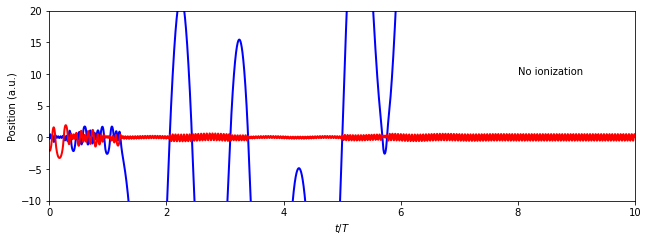

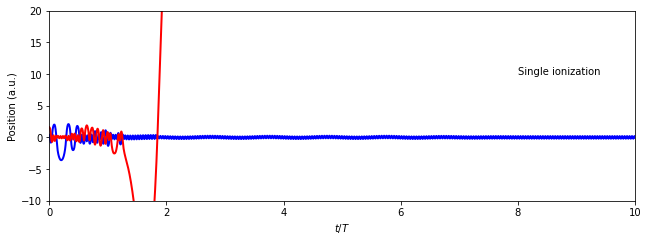

In [18]:
#@title Parameters  {display-mode: "form"}
Intensity = 4.6e14 #@param {type:"number"}
Number_of_trajectories = 2 #@param {type:"number"}

my_field = Field(wavelength=Wavelength_in_nm, intensity=Intensity, envelope=trapezoidal, params_envelop=params_envelop)


def eqn_motion_fig3(x, atom, field, integration):
    t = 0.0
    xf = x.copy()
    xt = np.empty((4,0))
    tt = []
    while t <= field.tf:
        e0_eff = field.amplitude * field.envelope(t, field) * np.sin(field.frequency * t)
        xf[:2] += integration.h * 0.5 * xf[2:]
        xf[2:] -= integration.h * (potential_2e(atom, xf[:2], is_deriv=True) + e0_eff)
        xf[:2] += integration.h * 0.5 * xf[2:]
        t += integration.h
        xt = np.hstack((xt,xf.reshape(4,1)))
        tt += [t]
    tt = np.array(tt)
    return tt, xt


parameters = Integration(N=10**2, step=h_step)
X0 = generate_initial_conditions(my_atom, parameters)
parameters.N = 1
for it in range(Number_of_trajectories):
    X0_traj = X0[:, it]
    Tt, Xt = eqn_motion_fig3(X0_traj, my_atom, my_field, parameters)
    R1 = np.abs(Xt[0, -1])
    R2 = np.abs(Xt[1, -1])
    if (R1 <= my_atom.thresh) and (R2 <= my_atom.thresh):
        label_ionization = "No ionization"
    elif (R1 >= my_atom.thresh) and (R2 >= my_atom.thresh):
        label_ionization = "Double ionization"
    else:
        label_ionization = "Single ionization"
    plt.figure(figsize=(10.5,3.5))
    plt.plot(Tt/my_field.period, Xt[0,:], color='b', linewidth=2)
    plt.plot(Tt/my_field.period, Xt[1,:], color='r', linewidth=2)
    plt.annotate(label_ionization, (8, 10))
    plt.xlabel('$t/T$')
    plt.ylabel('Position (a.u.)')
    plt.xlim([0, my_field.tf/my_field.period])
    plt.ylim([-10, 20])
    plt.show()

## Single ionization

By switching on the field, the outer electron is picked up and swept away from the nucleus. Consequently, its effective Hamiltonian is:
$$
{\mathcal H}_1=\frac{p_x^2}{2} + E_0 x f(t) \sin\omega t. \tag{2}
$$
We notice that Hamiltonian ${\mathcal H}_1$ is integrable. Its solutions are approximately composed of linear escape from the nucleus (at time $t_0$) modulated by the action of the field [2,37,38] (see the red trajectory in Fig. 3). 

For the inner electron, the effective Hamiltonian contains the interaction with the nucleus and with the laser field:
$$
{\mathcal H}_2=\frac{p_y^2}{2}-\frac{2}{\sqrt{y^2+a^2}}+yE_0\sin\omega t. \tag{3}
$$

In the absence of the field ($E_0=0$), ${\mathcal H}_2$ is also integrable and the inner electron is confined on a periodic orbit. Since it stays close to the nucleus, its approximate period is $2\pi a^{3/2}/\sqrt{2}$ obtained from the harmonic approximation, as observed in Fig. 3.

## Sequential double ionization (SDI)

Once an electron has been ionized (usually during the ramp-up of the field), the other electron is left with the nucleus and the field. Its effective Hamiltonian is ${\mathcal H}_2$. A contour plot of the electron excursions after two laser cycles and a Poincar\'e section of ${\mathcal H}_2$ are depicted in Fig. 4. They clearly show two distinct regions: 
The first one is the core region which is composed of a collection of invariant tori which are slight deformations of the ones obtained in the integrable case ${\mathcal H}_2$ without the field. This elliptic region is organized around a main elliptic periodic orbit which has the same period as the field $2\pi/\omega$. In this region, the electrons are fairly insensitive to the field, and do not ionize. The second region is the one outside the core where trajectories ionize quickly. It corresponds to sequential double ionization.  In between these two regions, any weak interaction (with the outer electron for instance) may move the inner electron confined on the outermost regular tori (but still inside the brown elliptical region) to the outer region where it ionizes quickly. 

If the laser intensity $I$ is too small, then the phase space is filled with invariant tori and no sequential double ionization can occur because the motion is regular. The sequential double ionization probability depends then on the size of the regular region around the elliptic periodic orbit, and hence on $I$.
We have numerically computed the location and the stability of this periodic orbit [35]. When it exists, this periodic orbit stays elliptic in the whole range of intensities we have considered. On the stroboscopic plot (with frequency $\omega$) the periodic orbit is located at $y=0$. In Fig. 4, the momentum $p_y$ of the periodic orbit on the stroboscopic plot is represented as a function of $I$. We notice that for a large set of intensities in the range $[10^{14}, 10^{16}]~ \mbox{W} / \mbox{cm}^{2}$, this periodic orbit is located close to $p_y= 0$. For intensities larger than a critical intensity $I_c$, the periodic orbit does not exist, and no major islands of regularity remain. Therefore, it is expected that the sequential double ionization probability is equal to one in this range of intensities, as observed on the probability curve on Fig. 1. The location of the local maximum of the potential of Hamiltonian (3) predicts that the intensity $I_c$ is approximately independent of $\omega$, and it is given by [$I_c\approx 16/(27a^4)$](#Figure-1).

## Figure 4: Upper panel: Contour plot of the electron location $y(t)$ of Hamiltonian (3), and Poincaré sections (stroboscopic plot) of selected trajectories in the elliptic central region. Lower panel: Momentum of the central periodic orbit (on the Poincaré section) of Hamiltonian (3) as a function of the laser intensity.

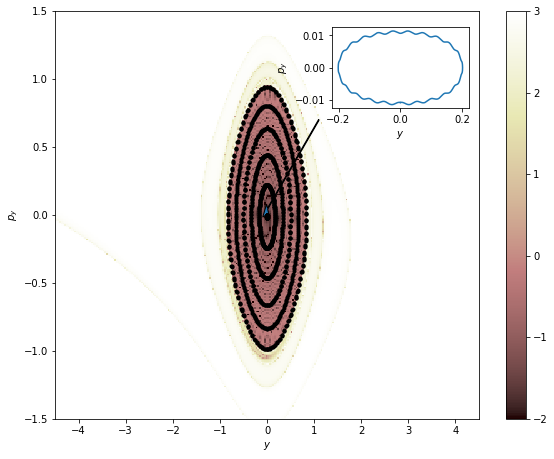

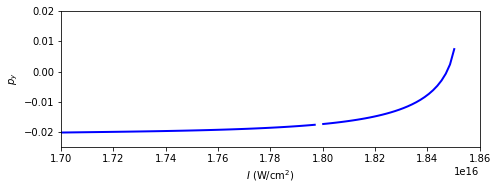

In [29]:
#@title Parameters  {display-mode: "form"}

#@markdown Upper Panel
Intensity = 5e15 #@param {type:"number"}
final_time_in_lc = 2 
y_max = 4.5
py_max = 1.5 
resolution = 256 #@param ["128", "256", "512", "1024"] {type:"raw"}
Number_of_Poincare_sections = 7

#@markdown Lower Panel
Imin = 1.7e16 #@param {type:"number"}
Imax = 1.86e16 #@param {type:"number"}
Number_of_intensities = 100


def eqn_motion_fig4a(y, py, atom, field, integration):
    t = 0.0
    yf = y.copy()
    pyf = py.copy()
    while t <= field.tf:
        e0_eff = field.amplitude * np.sin(field.frequency * t)
        yf += integration.h * 0.5 * pyf
        pyf -= integration.h * (potential_1e(atom, yf, is_deriv=True) + e0_eff)
        yf += integration.h * 0.5 * pyf
        t += integration.h
    return yf, pyf


def eqn_motion_fig4b(x, atom, field, integration, mem_traj=False):
    t = 0.0
    xf = x.copy()
    h = field.period/np.floor(field.period/integration.h)
    xt = np.empty((2,0))
    while t <= field.period:
        e0_eff = field.amplitude * np.sin(field.frequency * t)
        xf[0] += h * 0.5 * xf[1]
        xf[1] -= h * (potential_1e(atom, xf[0], is_deriv=True) + e0_eff)
        xf[0] += h * 0.5 * xf[1]
        t += h
        if mem_traj:
            xt = np.hstack((xt,xf.reshape(2,1)))
    if mem_traj:
        return xt
    else:     
        return xf-x


def eqn_motion_fig4c(x, atom, field, integration):
    xf = x.copy()
    h = field.period/np.floor(field.period/integration.h)
    xt = np.empty((2,0))
    for n_points in range(300):
        t = 0.0
        while t <= field.period:
            e0_eff = field.amplitude * np.sin(field.frequency * t)
            xf[0,] += h * 0.5 * xf[1,]
            xf[1,] -= h * (potential_1e(atom, xf[0,], is_deriv=True) + e0_eff)
            xf[0,] += h * 0.5 * xf[1,]
            t += h
        xt = np.hstack((xt,xf))
    return xt


y = np.linspace(-y_max, y_max, resolution)
py = np.linspace(-py_max, py_max, resolution)
my_field = Field(wavelength=Wavelength_in_nm, intensity=Intensity)
my_field.tf = final_time_in_lc * my_field.period
parameters = Integration(N=resolution**2, step=h_step, precision=np.float32)

yv, pyv = np.meshgrid(y, py)
yf, pyf = eqn_motion_fig4a(yv, pyv, my_atom, my_field, parameters)
r = np.abs(yf)

parameters = Integration(N=1, step=h_step/10, precision=np.float64)
xt0 = fsolve(eqn_motion_fig4b, [0.0, -0.02], args=(my_atom, my_field, parameters), xtol=1e-08, maxfev=30)
xt = eqn_motion_fig4b(xt0, my_atom, my_field, parameters, mem_traj=True)
parameters = Integration(N=Number_of_Poincare_sections, step=h_step, precision=np.float64)
xval = np.linspace(0.0, my_atom.a, Number_of_Poincare_sections)
X0 = np.vstack((xval,np.zeros(Number_of_Poincare_sections)))
Xt = eqn_motion_fig4c(X0, my_atom, my_field, parameters)

fig1 = plt.figure(figsize=(9.5,7.5))
pcol = plt.pcolor(yv, pyv, np.log10(r), cmap='pink', vmin=-2, vmax=3)
fig1.colorbar(pcol)
plt.plot(Xt[0, 3:], Xt[1, 3:], marker='.', color='k', linestyle='None')
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.xlim((-y_max, y_max))
plt.ylim((-py_max, py_max))
plt.arrow(1.1, 0.7, -1.088, -0.654, width = 0.01, head_width=0.08)
ax_inset = fig1.add_axes([0.53, 0.7, 0.2, 0.15])
ax_inset.plot(xt[0,:], xt[1,:])
ax_inset.set_xlabel('$y$')
ax_inset.set_ylabel('$p_y$')
plt.show()

Intensity_range = np.linspace(Imin, Imax, Number_of_intensities)
init_guess = [0.0, 0.0]
pdata = []
for intensity_element in Intensity_range:
    my_field = Field(wavelength=Wavelength_in_nm, intensity=intensity_element)
    xf, info, ier, msg = fsolve(eqn_motion_fig4b, init_guess, args=(my_atom, my_field, parameters), xtol=1e-08, maxfev=30, full_output=True)
    if ier == 1:
        pval = xf[1]
        init_guess = xf
    else:
        pval = np.nan
    pdata = np.append(pdata, pval)

fig2 = plt.figure(figsize=(7.5,2.5))
plt.plot(Intensity_range, pdata, linewidth=2, color='b')
plt.xlabel('$I$ (W/cm$^2$)')
plt.ylabel('$p_y$')
plt.xlim([Imin, Imax])
plt.ylim([-0.025, 0.02])
plt.show()

## Nonsequential double ionization (NSDI)

As noted before, when the field is turned on, its action is concentrated on only one electron, the outer one, as a first step.  The field drives the outer electron away from the nucleus, leaving the inner electron nearly unaffected by the field because its position remains small. 
From the recollision process [2,3], the outer electron might come back close to the nucleus during the pulse plateau, if the field amplitude is not too large. In this case, it transfers a part of its energy to the inner electron through the electron-electron interaction term. 
From then on, two outcomes are possible: If the energy brought in by the outer electron is sufficient for the other electron to escape from the regular region (as in Fig. 3, upper panel), then it might ionize together with the outer electron. The maximum energy ${\mathcal E}_x$ of the outer electron when it returns to the inner region (after having left the inner region with a small momentum $p_0$ close to zero) is obtained from Hamiltonian (2) and is
${\mathcal E}_x= \kappa U_p$, where $U_p=E_0^2/(4\omega^2)$ is the ponderomotive energy and $\kappa\approx 3.17$ is the maximum recollision kinetic energy in units of $U_p$ [2,37,38]. We complement the recollision scenario (which focuses on the outer electron) by providing the phase space picture of the inner electron: In order to ionize the core electron, the energy brought back by the outer electron has to be of order of the energy difference between the core ($y=0$) and the boundary of the stable region ($y=y_m$) of ${\mathcal H}_2$ (see Fig. 4) which is equal to
$$
\Delta {\mathcal E}_y=2-\frac{2}{\sqrt{y_m^2+a^2}}. \tag{4}
$$
A good approximation to $y_m=y_m(E_0)$ is given by the value where the potential is locally maximum, i.e. $E_0= 2y_m/(y_m^2+a^2)^{3/2}$.
The equal-sharing relation which links the classical picture of the outer electron $x$ with the one of the inner electron $y$,
$$
\Delta {\mathcal E}_y=\frac{{\mathcal E}_x}{2}= \frac{\kappa}{2\omega^2}\frac{y_m^2}{(y_m^2+a^2)^3}, \tag{5}
$$
defines (through an implicit equation) the expected value of the field $E_0^{(c)}$ for maximal NSDI, because it describes the case when each outer electron brings back enough energy to ionize the inner electron, while remaining ionized itself. However, fulfilling this energy requirement does not guarantee NSDI: The outcome depends on the number and efficiency of recollisions. The predicted value of the amplitude $E_0^{(c)}$ as given by Eq. (5) corresponds to an intensity $I^{(c)}$ given below which agrees very well with the simulations shown in Fig. 1.
In a wide range of frequencies, an accurate expansion of $E_0^{(c)}$ is obtained from Eqs. (4)-(5) and given by
$$
E_0^{(c)}= \frac{4\omega}{\sqrt{\kappa}}-\left(\frac{2\omega}{\sqrt{\kappa}} \right)^{3/2}+O\left(\frac{4\omega^2}{\kappa}\right), \tag{6}
$$
for sufficiently small $\omega$. To leading order the corresponding intensity varies as $\omega^2$. The approximate intensity given by Eq. (6) is in excellent agreement with Fig. 1.
When the field $E_0$ is too small, then the outer electron cannot gain enough energy to ionize the inner electron. When the field $E_0$ is too large, then the outer electron does not recollide since it leaves the interaction region nearly linearly. These two limits explain the bell shape of the resulting nonsequential double ionization probability, which, when put together with the monotonic rise of the SDI probability at higher intensities, adds up to the knee in question.

In [20]:
#@title Numerical values of the critical intensities {display-mode: "form"}
from IPython.display import display, Math, Latex


def fexp(f):
    return int(np.floor(np.log10(abs(f)))) if f != 0 else 0


def fman(f):
    return f/10**fexp(f)


kappa = 3.17
I0c = 3.51e16 * (4*my_field.frequency/np.sqrt(kappa)-(2*my_field.frequency/np.sqrt(kappa)) ** 1.5) **2
I0_c = 3.51e16 * 16/(27*my_atom.a **4)
display(Math(r'I_0^{{(c)}} \approx {:.2} \times 10^{{{}}}  ~{{\rm W / cm}}^2 \\ I_c \approx {:.2} \times 10^{{{}}}  ~{{\rm W / cm}}^2'.format(fman(I0c),fexp(I0c),fman(I0_c),fexp(I0_c))))

<IPython.core.display.Math object>



---


C. C. acknowledges financial support from the PICS
program of the CNRS. This work is partially funded by
NSF. We thank A. D. Bandrauk, W. Becker, and S. L. Haan
for useful discussions.

---


## References

[[1](http://link.aps.org/doi/10.1103/PhysRevLett.69.2642)] D. N. Fittinghoff, P. R. Bolton, B. Chang, and K. C.
Kulander, Phys. Rev. Lett. 69, 2642 (1992).

[[2](http://link.aps.org/doi/10.1103/PhysRevLett.71.1994)] P. B. Corkum, Phys. Rev. Lett. 71, 1994 (1993).

[[3](http://link.aps.org/doi/10.1103/PhysRevLett.70.1599)] K. J. Schafer, B. Yang, L. F. DiMauro, and K. C. Kulander, Phys. Rev. Lett. 70, 1599 (1993).

[[4](http://link.aps.org/doi/10.1103/PhysRevLett.73.1227)] B. Walker, B. Sheehy, L. F. DiMauro, P. Agostini, K. J.
Schafer, and K. C. Kulander, Phys. Rev. Lett. 73, 1227
(1994).

[[5a](http://dx.doi.org/10.1088/0953-4075/29/6/005), [5b](http://dx.doi.org/10.1088/0953-4075/32/14/101)] A. Becker and F. H. M. Faisal, J. Phys. B 29, L197 (1996); J. Phys. B 32, L335 ( 1999).

[[6](http://link.aps.org/doi/10.1103/PhysRevLett.85.3781)] R. Kopold, W. Becker, H. Rottke, and W. Sandner, Phys.
Rev. Lett. 85, 3781 (2000).

[[7](http://link.aps.org/doi/10.1103/PhysRevLett.85.4707)] M. Lein, E. K. U. Gross, and V. Engel, Phys. Rev. Lett. 85, 4707 (2000).

[[8](http://link.aps.org/doi/10.1103/PhysRevA.63.043414)] K. Sacha and B. Eckhardt, Phys. Rev. A 63, 043414
(2001).

[[9](http://link.aps.org/doi/10.1103/PhysRevA.63.043416)] L.-B. Fu, J. Liu, J. Chen, and S.-G. Chen, Phys. Rev. A 63, 043416 (2001).

[[10](https://doi.org/10.1364/OE.8.000431)] R. Panfili, J. H. Eberly, and S. L. Haan, Opt. Express 8, 431 (2001).

[[11](http://link.aps.org/doi/10.1103/PhysRevLett.93.053201)] J. Colgan, M. S. Pindzola, and F. Robicheaux, Phys. Rev. Lett. 93, 053201 (2004).

[[12](http://link.aps.org/doi/10.1103/PhysRevLett.94.093002)] P. J. Ho, R. Panfili, S. L. Haan, and J. H. Eberly, Phys. Rev. Lett. 94, 093002 (2005).

[[13](http://link.aps.org/doi/10.1103/PhysRevLett.95.193002)] P. J. Ho and J. H. Eberly, Phys. Rev. Lett. 95, 193002
(2005).

[[14](http://link.aps.org/doi/10.1103/PhysRevLett.94.063002)] C. Ruiz, L. Plaja, and L. Roso, Phys. Rev. Lett. 94, 063002 (2005).

[[15](http://link.aps.org/doi/10.1103/PhysRevA.76.030701)] D. A. Horner, F. Morales, T. N. Rescigno, F. Martin, and C.W. McCurdy, Phys. Rev. A 76, 030701(R) (2007).

[[16](http://link.aps.org/doi/10.1103/PhysRevLett.98.203002)] J. S. Prauzner-Bechcicki, K. Sacha, B. Eckhardt, and
J. Zakrzewski, Phys. Rev. Lett. 98, 203002 (2007).

[[17](http://link.aps.org/doi/10.1103/PhysRevA.77.043420)] J. Feist, S. Nagele, R. Pazourek, E. Persson, B. I.
Schneider, L.A. Collins, and J. Burgdörfer, Phys. Rev. A
77, 043420 (2008).

[[18](http://dx.doi.org/10.1140/epjd/e2003-00272-8)] I. F. Barna and J. M. Rost, Eur. Phys. J. D 27, 287 (2003).

[[19](http://dx.doi.org/10.1038/nphys310)] W. A. Bryan, S. L. Stebbings, J. McKenna, E. M. L.
English, M. Suresh, J. Wood, B. Srigengan, I. C. E.
Turcu, J. M. Smith, and E. J. Divall et al., Nature Phys.
2, 379 (2006).

[[20](http://dx.doi.org/10.1038/35015033)] T. Weber, H. Giessen, M. Weckenbrock, G. Urbasch, A.
Staudte, L. Spielberger, O. Jagutzki, V. Mergel, M.
Vollmer, and R. Dörner, Nature (London) 405, 658 (2000).

[[21](http://link.aps.org/doi/10.1103/PhysRevA.48.R2531)] K. Kondo, A. Sagisaka, T. Tamida, Y. Nabekawa, and S.
Watanabe, Phys. Rev. A 48, R2531 (1993).

[[22](http://dx.doi.org/10.1088/0953-4075/31/6/008)] S. Larochelle, A. Talebpour, and S. L. Chin, J. Phys. B 31, 1201 (1998).

[[23](http://link.aps.org/doi/10.1103/PhysRevA.62.023403)] C. Cornaggia and P. Hering, Phys. Rev. A 62, 023403
(2000).

[[24](http://link.aps.org/doi/10.1103/PhysRevA.63.040701)] C. Guo and G. N. Gibson, Phys. Rev. A 63, 040701 (2001).

[[25](http://link.aps.org/doi/10.1103/PhysRevLett.87.153001)] M. J. DeWitt, E. Wells, and R. R. Jones, Phys. Rev. Lett. 87, 153001 (2001).

[[26](http://link.aps.org/doi/10.1103/PhysRevLett.92.203001)] J. Rudati, J. L. Chaloupka, P. Agostini, K. C. Kulander, and L. F. DiMauro, Phys. Rev. Lett. 92, 203001 (2004).

[[27](http://link.aps.org/doi/10.1103/PhysRevLett.78.1884)] J. B. Watson, A. Sanpera, D. G. Lappas, P. L. Knight, and K. Burnett, Phys. Rev. Lett. 78, 1884 (1997).

[[28](http://dx.doi.org/10.1088/0953-4075/31/6/001)] D. G. Lappas and R. van Leeuwen, J. Phys. B 31, L249
(1998).

[[29](http://link.aps.org/doi/10.1103/PhysRevA.67.043402)] R. Panfili and W.-C. Liu, Phys. Rev. A 67, 043402 (2003).

[[30](http://link.aps.org/doi/10.1103/PhysRevLett.89.113001)] R. Panfili, S. L. Haan, and J. H. Eberly, Phys. Rev. Lett. 89, 113001 (2002).

[[31](http://link.aps.org/doi/10.1103/PhysRevLett.99.013003)] J. Liu, D. F. Ye, J. Chen, and X. Liu, Phys. Rev. Lett. 99, 013003 (2007).

[[32](http://link.aps.org/doi/10.1103/PhysRevA.44.5997)] Q. Su and J. H. Eberly, Phys. Rev. A 44, 5997 (1991).

[[33](http://link.aps.org/doi/10.1103/PhysRevA.38.3430)] J. Javanainen, J. H. Eberly, and Q. Su, Phys. Rev. A 38, 3430 (1988).

[[34](http://link.aps.org/doi/10.1103/PhysRevA.50.378)] S. L. Haan, R. Grobe, and J. H. Eberly, Phys. Rev. A 50, 378 (1994).

[[35](http://chaosbook.org)] P. Cvitanovic, R. Artuso, R. Mainieri, G. Tanner, and G. Vattay, Chaos: Classical and Quantum (Niels Bohr
Institute, Copenhagen, 2008).

[[36](http://link.aps.org/doi/10.1103/PhysRevA.74.043417)] E. Shchekinova, C. Chandre, and T. Uzer, Phys. Rev. A 74, 043417 (2006).

[[37](http://link.aps.org/doi/10.1103/PhysRevA.50.1540)] W. Becker, S. Long, and J. K. McIver, Phys. Rev. A 50,
1540 (1994).

[[38](http://dx.doi.org/10.1080/09500340410001729582)] A. D. Bandrauk, S. Chelkowski, and S. Goudreau, J. Mod.
Opt. 52, 411 (2005).


